In [8]:
!python test.py --model BERT4Rec --dataset sports --cuda 2

{'optimizer': {'name': 'adam', 'lr': 0.001, 'weight_decay': 0}, 'train': {'epoch': 200, 'batch_size': 512, 'save_model': True, 'log_loss': False, 'test_step': 1, 'reproducible': True, 'seed': 2023, 'pretrain_path': '/home/asaliao/SSLRec/checkpoint/bert4rec/bert4rec-sports-1710580531.pth', 'early_stop': False}, 'test': {'metrics': ['recall', 'ndcg', 'mrr'], 'k': [5, 10, 20], 'batch_size': 512}, 'data': {'type': 'sequential', 'name': 'sports', 'dir': './datasets/sequential/sports_seq/', 'user_num': 85226, 'item_num': 56974}, 'model': {'name': 'bert4rec', 'dropout_rate': 0.1, 'n_layers': 2, 'embedding_size': 64, 'mask_prob': 0.2, 'n_heads': 2, 'max_seq_len': 50}, 'tune': {'enable': False, 'hyperparameters': [], 'layer_num': [], 'reg_weight': []}, 'device': 'cuda'}
Load model parameters from /home/asaliao/SSLRec/checkpoint/bert4rec/bert4rec-sports-1710580531.pth
OrderedDict([('emb_layer.token_emb.weight', tensor([[-0.0229, -0.0408,  0.0020,  ..., -0.0105, -0.0431,  0.0527],
        [ 0.301

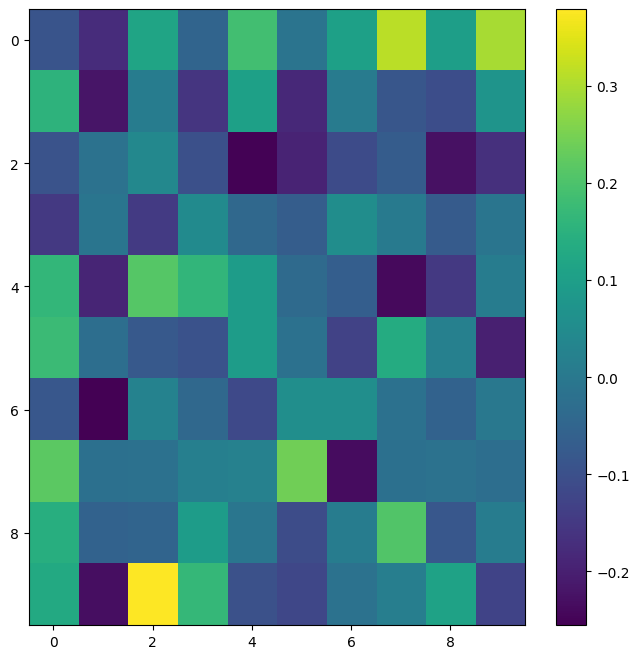

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

pretrain_path = "/home/asaliao/SSLRec/checkpoint/bert4rec/bert4rec-sports-1710580531.pth"
model = torch.load(pretrain_path)
# model.load_state_dict()

# average_attention_weights = np.mean(model['transformer_layers.0.attention.output_linear.weight'])#, axis=1)

# attention_weights = model['transformer_layers.0.attention.linear_layers.1.weight'][-10:, -10:].cpu().numpy()
attention_weights = model['transformer_layers.1.attention.output_linear.weight'][-10:, -10:].cpu().numpy()
# 绘制热力图
plt.figure(figsize=(8, 8))
plt.imshow(attention_weights, cmap='viridis', aspect='auto', interpolation='nearest')
# plt.imshow(attention_weights, cmap='hot', interpolation='nearest')
plt.colorbar()
# plt.xlabel('Output Dimension')
# plt.ylabel('Input Dimension')
# plt.title('Attention Weights of First Attention Layer')
plt.show()

In [3]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.9 MB/s eta 0:00:00ta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.0.201 requires opencv-python>=4.6.0, which is not installed.
ultralytics 8.0.201 requires py-cpuinfo, which is not installed.


In [21]:
import pandas as pd
import csv

# 读取数据集
data = pd.read_csv("/home/asaliao/SSLRec/datasets/sequential/reddit_seq/train.tsv", delimiter="\t", names=["session_id:token", "item_id_list:token_seq", "item_id:token"]) # 替换成你的数据集路径

# 将序列长度添加为新列
data['seq_length'] = data['item_id_list:token_seq'].apply(lambda x: len(x.split()))

# 定义序列长度区间
bins = [0, 5, 10, 20, 30, 40, 50]  # 根据需要自定义区间

# 将数据集根据序列长度分布分成四个子数据集
for i in range(len(bins)-1):
    start = bins[i]
    end = bins[i+1]
    subset = data[(data['seq_length'] >= start) & (data['seq_length'] < end)]
    subset.drop(columns=['seq_length'], inplace=True)  # 删除添加的序列长度列
    subset = subset.reset_index(drop=True)  # 重置索引
    subset['session_id:token'] = subset.index  # 使用新索引作为 session_id
    subset.to_csv(f"reddit_{start}_{end}.tsv", sep='\t', index=False, header=True, quoting=csv.QUOTE_NONE)

print("子数据集已保存。")


子数据集已保存。


/tmp/ipykernel_2803266/613082452.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.drop(columns=['seq_length'], inplace=True)  # 删除添加的序列长度列
/tmp/ipykernel_2803266/613082452.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.drop(columns=['seq_length'], inplace=True)  # 删除添加的序列长度列
/tmp/ipykernel_2803266/613082452.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.drop(columns=['seq_length'], inplace=True)  # 

In [23]:
items = data['item_id_list:token_seq'].str.split(expand=True).stack()#.astype(int)
items = items.reset_index(level=1, drop=True).rename('item_id')

# 计算 item 的流行度
item_counts = items.value_counts()

# 取前 200 个流行度最高的 item
top_200_items = item_counts.head(200).index.tolist()

print(top_200_items)

['7647', '13170', '441', '8887', '1502', '10933', '3652', '3012', '12372', '4122', '9750', '10090', '6266', '6275', '3533', '9794', '5961', '7203', '12874', '8969', '14066', '6118', '12911', '6569', '8763', '1930', '14204', '5265', '10075', '11145', '12691', '5863', '8635', '3127', '6616', '11306', '5633', '5858', '8213', '1587', '5626', '4806', '2221', '1535', '766', '592', '3505', '14675', '8147', '5958', '2259', '4666', '4263', '14056', '9232', '14199', '8602', '12779', '1194', '8261', '8250', '13354', '9262', '9381', '1226', '12918', '10062', '9298', '11899', '5438', '11', '9168', '13046', '8291', '2982', '6376', '12245', '1652', '11229', '11712', '940', '349', '2141', '418', '3488', '5566', '770', '7687', '12211', '10383', '11859', '7854', '1630', '3699', '11128', '9292', '5719', '14320', '9183', '1931', '8861', '1557', '15046', '8684', '3100', '3209', '8931', '11106', '12597', '6537', '5897', '11029', '9920', '8403', '8711', '7075', '12067', '10178', '10060', '14486', '2841', '14

In [28]:
import pandas as pd
import csv

# 读取数据集
data = pd.read_csv("/home/asaliao/SSLRec/datasets/sequential/reddit_seq/train.tsv", delimiter="\t", names=["session_id:token", "item_id_list:token_seq", "item_id:token"]) # 替换成你的数据集路径

items = data['item_id_list:token_seq'].str.split(expand=True).stack()#.astype(int)
items = items.reset_index(level=1, drop=True).rename('item_id')

# 计算 item 的流行度
item_counts = items.value_counts()

# 取前 200 个流行度最高的 item
top_200_items = item_counts.head(200).index.tolist()
top_200_items = [int(item) for item in top_200_items]

print(top_200_items)

[7647, 13170, 441, 8887, 1502, 10933, 3652, 3012, 12372, 4122, 9750, 10090, 6266, 6275, 3533, 9794, 5961, 7203, 12874, 8969, 14066, 6118, 12911, 6569, 8763, 1930, 14204, 5265, 10075, 11145, 12691, 5863, 8635, 3127, 6616, 11306, 5633, 5858, 8213, 1587, 5626, 4806, 2221, 1535, 766, 592, 3505, 14675, 8147, 5958, 2259, 4666, 4263, 14056, 9232, 14199, 8602, 12779, 1194, 8261, 8250, 13354, 9262, 9381, 1226, 12918, 10062, 9298, 11899, 5438, 11, 9168, 13046, 8291, 2982, 6376, 12245, 1652, 11229, 11712, 940, 349, 2141, 418, 3488, 5566, 770, 7687, 12211, 10383, 11859, 7854, 1630, 3699, 11128, 9292, 5719, 14320, 9183, 1931, 8861, 1557, 15046, 8684, 3100, 3209, 8931, 11106, 12597, 6537, 5897, 11029, 9920, 8403, 8711, 7075, 12067, 10178, 10060, 14486, 2841, 14183, 13020, 15232, 8089, 3760, 4523, 1852, 1275, 14653, 14952, 7234, 14649, 2483, 14690, 6921, 6107, 598, 13589, 13680, 14483, 12504, 6691, 7154, 2778, 931, 7697, 8240, 4130, 1424, 7850, 7146, 964, 13681, 12778, 12689, 9059, 10827, 10305, 8669

In [1]:
# 导入所需库
import pandas as pd

# 读取数据集
data = pd.read_csv("/home/asaliao/SSLRec/datasets/sequential/reddit_seq/train.tsv", delimiter="\t", names=["session_id", "item_id_list", "item_id"])

# 计算数据的稀疏程度
sparsity = 1.0 - data.shape[0] / (data["session_id"].nunique() * data["item_id"].nunique())

# 计算序列长度分布特征
sequence_lengths = data["item_id_list"].apply(lambda x: len(x.split()))
max_sequence_length = sequence_lengths.max()
min_sequence_length = sequence_lengths.min()
mean_sequence_length = sequence_lengths.mean()

# 打印结果
print("数据的稀疏程度：", sparsity)
print("序列长度的最大值：", max_sequence_length)
print("序列长度的最小值：", min_sequence_length)
print("序列长度的平均值：", mean_sequence_length)


数据的稀疏程度： 0.9997180716098111
序列长度的最大值： 49
序列长度的最小值： 1
序列长度的平均值： 19.950369296610756


In [2]:
data = pd.read_csv("/home/asaliao/SSLRec/datasets/sequential/ml-20m_seq/train.tsv", delimiter="\t", names=["session_id", "item_id_list", "item_id"])

# 计算数据的稀疏程度
sparsity = 1.0 - data.shape[0] / (data["session_id"].nunique() * data["item_id"].nunique())

# 计算序列长度分布特征
sequence_lengths = data["item_id_list"].apply(lambda x: len(x.split()))
max_sequence_length = sequence_lengths.max()
min_sequence_length = sequence_lengths.min()
mean_sequence_length = sequence_lengths.mean()

# 打印结果
print("数据的稀疏程度：", sparsity)
print("序列长度的最大值：", max_sequence_length)
print("序列长度的最小值：", min_sequence_length)
print("序列长度的平均值：", mean_sequence_length)

数据的稀疏程度： 0.999830191883172
序列长度的最大值： 49
序列长度的最小值： 1
序列长度的平均值： 17.19576746926918


In [3]:
data = pd.read_csv("/home/asaliao/SSLRec/datasets/sequential/sports_seq/train.tsv", delimiter="\t", names=["session_id", "item_id_list", "item_id"])

# 计算数据的稀疏程度
sparsity = 1.0 - data.shape[0] / (data["session_id"].nunique() * data["item_id"].nunique())

# 计算序列长度分布特征
sequence_lengths = data["item_id_list"].apply(lambda x: len(x.split()))
max_sequence_length = sequence_lengths.max()
min_sequence_length = sequence_lengths.min()
mean_sequence_length = sequence_lengths.mean()

# 打印结果
print("数据的稀疏程度：", sparsity)
print("序列长度的最大值：", max_sequence_length)
print("序列长度的最小值：", min_sequence_length)
print("序列长度的平均值：", mean_sequence_length)

数据的稀疏程度： 0.9999689893633517
序列长度的最大值： 49
序列长度的最小值： 1
序列长度的平均值： 2.69726729792202


In [4]:
data = pd.read_csv("/home/asaliao/SSLRec/datasets/sequential/beauty_seq/train.tsv", delimiter="\t", names=["session_id", "item_id_list", "item_id"])

# 计算数据的稀疏程度
sparsity = 1.0 - data.shape[0] / (data["session_id"].nunique() * data["item_id"].nunique())

# 计算序列长度分布特征
sequence_lengths = data["item_id_list"].apply(lambda x: len(x.split()))
max_sequence_length = sequence_lengths.max()
min_sequence_length = sequence_lengths.min()
mean_sequence_length = sequence_lengths.mean()

# 打印结果
print("数据的稀疏程度：", sparsity)
print("序列长度的最大值：", max_sequence_length)
print("序列长度的最小值：", min_sequence_length)
print("序列长度的平均值：", mean_sequence_length)

数据的稀疏程度： 0.999956771711408
序列长度的最大值： 49
序列长度的最小值： 1
序列长度的平均值： 2.670002990378019


In [3]:
import pickle
train_mat_neg = pickle.load(open('/home/asaliao/SSLRec/datasets/multi_behavior/retail_rocket/train_mat_buy.pkl', 'rb'))
train_mat_neg

<2174x30113 sparse matrix of type '<class 'numpy.int64'>'
	with 9551 stored elements in Compressed Sparse Row format>

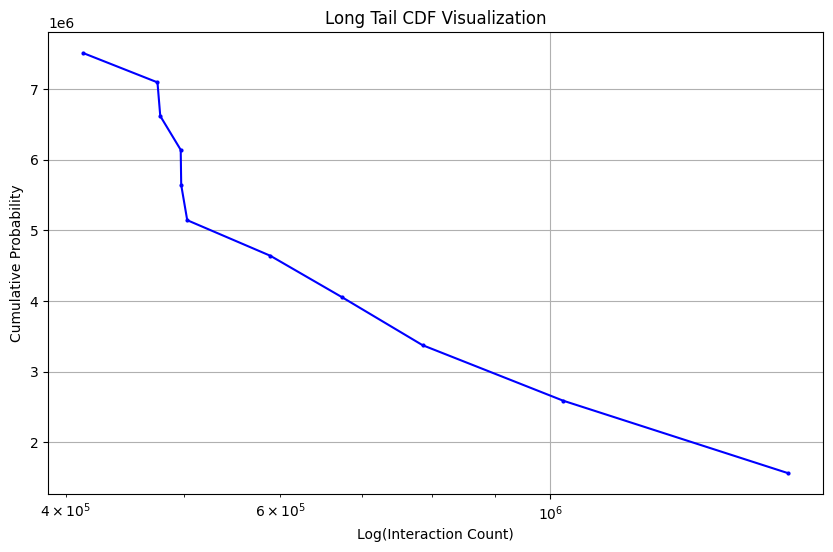

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设df是包含你的数据的DataFrame
df = pd.read_csv("/home/asaliao/SSLRec/datasets/sequential/ml-20m_seq/train.tsv", sep='\t', header=0)#.astype('int')

# 创建一个包含所有item_id的列表
all_items = [item for sublist in df['item_id_seq'] for item in sublist]
all_items_set = set(all_items)

# 计算每个item_id的交互次数
interaction_counts = [all_items.count(item) for item in all_items_set]

# 将交互次数进行排序
sorted_interaction_counts = sorted(interaction_counts, reverse=True)

# 计算累积分布函数（CDF）
cdf = [sum(sorted_interaction_counts[:i + 1]) for i in range(len(sorted_interaction_counts))]

# 绘制CDF图
plt.figure(figsize=(10, 6))
plt.plot(sorted_interaction_counts, cdf, color='blue', marker='o', linestyle='-', markersize=2)
plt.xscale('log')  # 使用对数尺度，更好地展示长尾
plt.xlabel('Log(Interaction Count)')#对数尺度每个点表示在数据集中有至少这么多次交互的item的数量。横坐标为2，表示有至少10^2=100次交互的item的数量
plt.ylabel('Cumulative Probability')#累积概率，即有至少这么多次交互的item占总item数量的比例。纵坐标为0.8，表示有至少这么多次交互的item占总item数量的80%。
plt.title('Long Tail CDF Visualization')
plt.grid(True)
plt.show()
'''长尾的程度： 长尾分布的尾部有多长 即在图的右侧有多少item。这可以通过观察图的尾部来判断。

前百分之多少的item贡献了多少的交互  可以通过查看图的横坐标在某个值 例如 横坐标为2 时的纵坐标值来了解。横坐标为2时 纵坐标为0.8 表示前百分之80的item贡献了至少100次的交互。

是否存在冷启动： CDF图的起始部分表示交互次数较少的item。如果起始部分有很多item 则存在冷启动问题'''


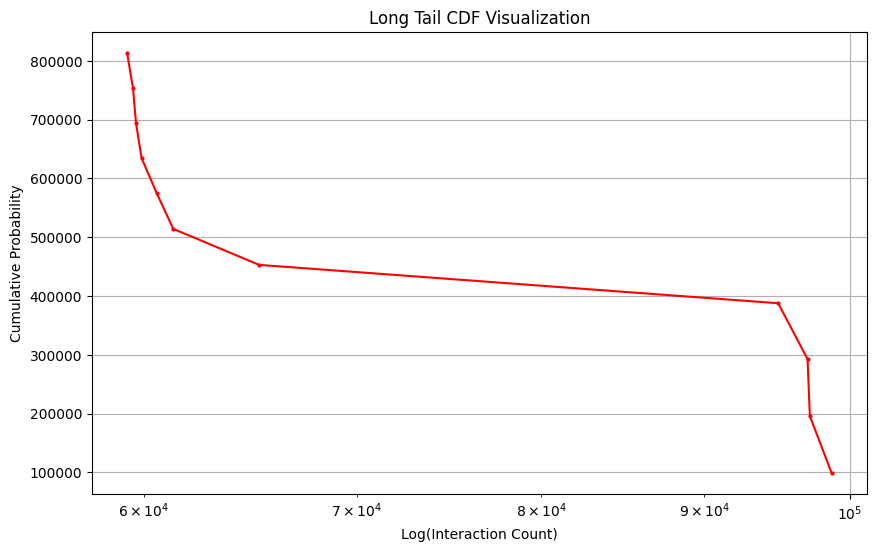

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

df2 = pd.read_csv("/home/asaliao/SSLRec/datasets/sequential/beauty_seq/train.tsv", sep='\t', header=0)#.astype('int')


all_items = [item for sublist in df2['item_id_list:token_seq'] for item in sublist]
all_items_set = set(all_items)

# 计算每个item_id的交互次数
interaction_counts = [all_items.count(item) for item in all_items_set]

# 将交互次数进行排序
sorted_interaction_counts = sorted(interaction_counts, reverse=True)

# 计算累积分布函数（CDF）
cdf = [sum(sorted_interaction_counts[:i + 1]) for i in range(len(sorted_interaction_counts))]

# 绘制CDF图
plt.figure(figsize=(10, 6))
plt.plot(sorted_interaction_counts, cdf, color='red', marker='o', linestyle='-', markersize=2)
plt.xscale('log')  # 使用对数尺度，更好地展示长尾
plt.xlabel('Log(Interaction Count)')#对数尺度每个点表示在数据集中有至少这么多次交互的item的数量。横坐标为2，表示有至少10^2=100次交互的item的数量
plt.ylabel('Cumulative Probability')#累积概率，即有至少这么多次交互的item占总item数量的比例。纵坐标为0.8，表示有至少这么多次交互的item占总item数量的80%。
plt.title('Long Tail CDF Visualization')
plt.grid(True)
plt.show()


In [2]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, item_count, embedding_size, output_size, n1):
        super(CustomModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(item_count, embedding_size)

        # Learnable global matrix A_i
        self.A_i = nn.Parameter(torch.randn(item_count, item_count))

        # Learnable matrix A_N with prior
        self.A_N = nn.Parameter(torch.randn(item_count, item_count))

        # Apply prior to A_N (set diagonal elements to 0)
        self.A_N.data = self.apply_prior(self.A_N.data, item_count)
        print(self.A_N)

        # Linear layer
        self.linear = nn.Linear(embedding_size, output_size)

    def apply_prior(self, matrix, item_count):
        # Set diagonal elements to 0
        matrix[torch.arange(item_count), torch.arange(item_count)] = 0
        return matrix

    def forward(self, input_sequence):
        # Embedding
        embedded_sequence = self.embedding(input_sequence)

        # Take the corresponding part of A_i based on the items in the sequence
        A_i_batched = self.A_i.index_select(0, input_sequence.view(-1)).view(input_sequence.size(0), input_sequence.size(1), -1)

        # Multiply A_i with embedded_sequence
        latent_representation = torch.bmm(A_i_batched, embedded_sequence)

        # Learnable matrix A_K with prior
        A_K = 0.5 * ((A_i_batched + self.A_N) + (A_i_batched + self.A_N).t())

        # Linear layer
        output = self.linear(latent_representation)

        return output

# Example usage
item_count = 1000  # Example item count
embedding_size = 64  # Example embedding size
output_size = 10  # Example output size
n1 = 0.5  # Example prior value for diagonal elements

# Create model
model = CustomModel(item_count, embedding_size, output_size, n1)

# Example input sequence
input_sequence = torch.randint(0, item_count, (512, 50))  # Batch size of 512, sequence length of 50

# Forward pass
output = model(input_sequence)

# Print the output size
print(output.size())


Parameter containing:
tensor([[ 0.0000e+00, -5.8309e-01, -9.9668e-01,  ...,  6.1946e-01,
         -4.4380e-04,  5.2486e-01],
        [-4.9554e-01,  0.0000e+00,  6.4334e-01,  ...,  9.4774e-01,
          2.8189e-01, -1.2976e+00],
        [-3.8361e-03,  9.1032e-01,  0.0000e+00,  ..., -8.7359e-01,
          7.7236e-01, -1.2318e+00],
        ...,
        [ 1.7496e-01,  6.6068e-01,  5.5226e-01,  ...,  0.0000e+00,
          3.6369e-01, -3.3428e-01],
        [-3.2777e-01,  1.7754e+00, -8.8207e-03,  ..., -1.0762e+00,
          0.0000e+00,  8.3566e-01],
        [ 6.2144e-01, -1.7399e+00, -2.0290e-01,  ..., -1.4851e+00,
          1.3125e+00,  0.0000e+00]], requires_grad=True)


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [512, 1000] but got: [512, 50].